In [15]:
import numpy as np
import mnist_reader

# subset selection

# 1. 讀取資料
x_train, y_train = mnist_reader.load_data('data/oracle', kind='train')
x_test, y_test = mnist_reader.load_data('data/oracle', kind='t10k')

# 2. 將每張圖 reshape 成 28x28，再取中心的 14x14，flatten
def center_crop_14x14(flat_images):
    # reshape 為 (N, 28, 28)
    images = flat_images.reshape(-1, 28, 28)
    # 取中心 14x14：從 index 7 到 21（不含 21）
    cropped = images[:, 7:21, 7:21]
    # flatten 為 (N, 196)
    return cropped.reshape(-1, 14*14)

# 3. 處理 train 和 test
x_train_center = center_crop_14x14(x_train)
x_test_center = center_crop_14x14(x_test)

The size of train set: 27222
The size of t10k set: 3000


In [ ]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import adjusted_rand_score

# subset selection + K-mean clustering

# 假設你想用 K = 10（例如模擬分成 10 種筆跡風格）
k = 10

# 建立模型並訓練
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(x_train_center)

# 取得每筆資料的分群結果
cluster_labels = kmeans.labels_  # shape = (樣本數,)

def show_cluster_samples(images, labels, cluster_id, n=5):
    idx = np.where(labels == cluster_id)[0][:n]
    plt.figure(figsize=(10, 2))
    for i, image_index in enumerate(idx):
        img = images[image_index].reshape(14, 14)
        plt.subplot(1, n, i+1)
        plt.imshow(img, cmap='gray')
        plt.axis('off')
    plt.suptitle(f"Samples from cluster {cluster_id}")
    plt.show()

# 看第 0 群的樣本
show_cluster_samples(x_train_center, cluster_labels, cluster_id=0)

# 與原始 y_train 做比較（因為 K-means 是 unsupervised，不能直接比對，但可用 ARI）
score = adjusted_rand_score(y_train, cluster_labels)
print(f"Adjusted Rand Index: {score:.4f}") # Adjusted Rand Index: 0.0561

In [17]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import adjusted_rand_score
import matplotlib.pyplot as plt
import numpy as np
import mnist_reader

# # subset selection + EM algorithm

# 1. 讀資料
x_train, y_train = mnist_reader.load_data('data/oracle', kind='train')

# 2. 中心裁切 14x14
def center_crop_14x14(flat_images):
    images = flat_images.reshape(-1, 28, 28)
    cropped = images[:, 7:21, 7:21]
    return cropped.reshape(-1, 14 * 14)

x_train_center = center_crop_14x14(x_train)

# 3. 用 Gaussian Mixture Model 做 clustering（等同 EM）
n_components = 10  # 例如你想分成10群（可能對應0~9）
gmm = GaussianMixture(n_components=n_components, covariance_type='full', random_state=42)
gmm.fit(x_train_center)

# 4. 得到每筆資料的 cluster 編號
gmm_labels = gmm.predict(x_train_center)

# 5. 評估 clustering 跟真實標籤的關係（unsupervised 不應完全對應，但可以量化）
ari = adjusted_rand_score(y_train, gmm_labels)
print(f"Adjusted Rand Index (GMM clustering): {ari:.4f}") # Adjusted Rand Index (GMM clustering): 0.1180


The size of train set: 27222


c:\Users\ted12\anaconda3\envs\NLP\Lib\site-packages\sklearn\mixture\_base.py:286: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Adjusted Rand Index (GMM clustering): 0.1180


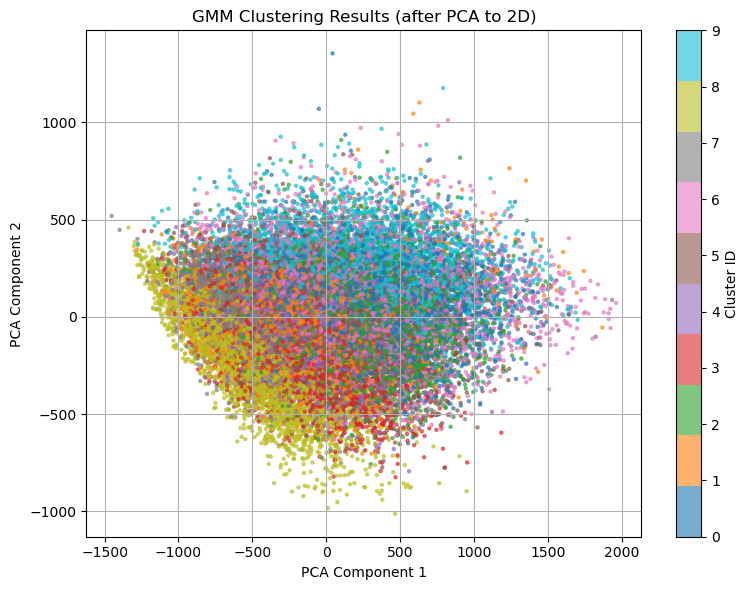

In [18]:
from sklearn.decomposition import PCA

# 6. 使用 PCA 將 196 維降到 2 維，方便視覺化
pca = PCA(n_components=2)
x_train_pca = pca.fit_transform(x_train_center)

# 7. 視覺化 GMM clustering 結果
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    x_train_pca[:, 0], x_train_pca[:, 1],
    c=gmm_labels, cmap='tab10', s=5, alpha=0.6
)
plt.title("GMM Clustering Results (after PCA to 2D)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(scatter, label="Cluster ID")
plt.grid(True)
plt.tight_layout()
plt.show()
